In [30]:
import numpy as np
np.random.seed(2016)
import scipy
import os
import glob
import math
import pickle
import datetime
#import pandas as pd

from keras.applications import vgg16 as keras_vgg16
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D,Conv2D
from keras.layers import Activation, Dropout, Flatten, Dense ,Input, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.optimizers import RMSprop
from keras.optimizers import Adam
from keras.layers.core import  ActivityRegularization

import json, sys

import keras
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras.preprocessing import image

import matplotlib.pyplot as plt

In [2]:
w_img, h_img = 224, 224

training_path = 'train'
validation_path = 'validation'
testing_path = 'test'

classes = 7;
BATCH_SIZE = 16;
EPOCHS_NB = 1;

input_shape = (224,224,3)

num_train_samples = sum([len(files) for r, d, files in os.walk(training_path)])
num_valid_samples = sum([len(files) for r, d, files in os.walk(validation_path)])
num_test_samples = sum([len(files) for r, d, files in os.walk(testing_path)])

print(num_train_samples)
print(num_valid_samples)
print(num_test_samples)

num_train_steps = math.floor(num_train_samples/BATCH_SIZE)
num_valid_steps = math.floor(num_valid_samples/BATCH_SIZE)

print(num_train_steps)
print(num_valid_steps)

902
432
147
56
27


In [3]:
# Data augmentation
"""
train_batches = ImageDataGenerator(rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True).flow_from_directory(training_path, target_size=(w_img,h_img), batch_size=BATCH_SIZE)
valid_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(validation_path, target_size=(w_img,h_img), batch_size=BATCH_SIZE)
test_batches = ImageDataGenerator(rescale=1./255).flow_from_directory(testing_path, target_size=(w_img,h_img), batch_size=4)
"""

train_batches = ImageDataGenerator().flow_from_directory(training_path, target_size=(w_img,h_img), batch_size=BATCH_SIZE)
valid_batches = ImageDataGenerator().flow_from_directory(validation_path, target_size=(w_img,h_img), batch_size=BATCH_SIZE)
test_batches = ImageDataGenerator().flow_from_directory(testing_path, target_size=(w_img,h_img), batch_size=4)

Found 902 images belonging to 7 classes.
Found 432 images belonging to 7 classes.
Found 147 images belonging to 7 classes.


In [4]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=4, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

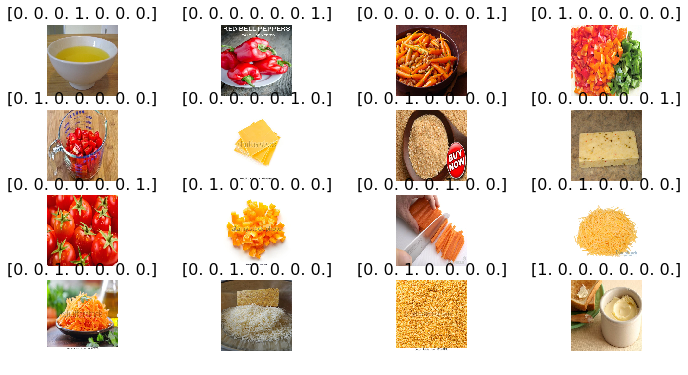

In [5]:
imgs, labels = next(train_batches)

plots(imgs, titles=labels)

In [6]:
# Create a Model
X_input = Input(input_shape)

#X = ZeroPadding2D((3, 3))(X_input)

modelResNet = keras.applications.resnet50.ResNet50(include_top=False,  weights='imagenet', input_tensor=X_input)

In [28]:
modelResNet.summary()
#modelResNet.get_weights()

In [8]:
#Freeze layers in resnet and do not update weights while trainng model.
for layer in modelResNet.layers:
        layer.trainable=False

In [39]:
#X = modelResNet(X_input)

last_layer = modelResNet.get_layer('avg_pool').output
#last_layer = modelResNet.output
#last_layer = GlobalAveragePooling2D()(last_layer)
newLayers = Conv2D(1024, (3, 3), name='convNew', padding='same')(last_layer)
last_layer = GlobalAveragePooling2D()(last_layer)
#newLayers = BatchNormalization(axis=1, name='bnNew')(newLayers)
newLayers = Activation('relu')(newLayers)

# MAXPOOL
#X= MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(X)
#X = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='maxPoolNew')(X)

## FLATTEN X (means convert it to a vector) + FULLYCONNECTED
X = Flatten()(newLayers)
output = Dense(classes, activation='softmax', name='fc' + str(classes))(newLayers)

In [40]:
#Model to train 
newModelResNet = Model(input=X_input, outputs=output)

newModelResNet.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("fc..., inputs=Tensor("in...)`
  


In [41]:
rmsProp =RMSprop( lr=0.0001)
#adm = Adam(lr=0.0001)

newModelResNet.compile(optimizer=rmsProp, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [42]:
# Model Checkpoint
filepath="weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkPoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkPoint]


In [43]:

newModelResNet.fit_generator(
        train_batches,
        steps_per_epoch=num_train_steps,
        epochs=EPOCHS_NB,
        validation_data=valid_batches,
        validation_steps=num_valid_steps,
        callbacks=callbacks_list)

Epoch 1/1


ValueError: Error when checking target: expected fc7 to have 4 dimensions, but got array with shape (16, 7)

In [19]:
score = newModelResNet.evaluate_generator(test_batches, num_test_samples)
print("Accuracy = ", score[1])

newModelResNet.save_weights('Weights_v1.h5')

ValueError: Error when checking target: expected fc7 to have 4 dimensions, but got array with shape (4, 7)